In [9]:
import pandas as pd
import os
import json
import requests
import time

from scipy.stats import kstest,ttest_ind
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages


In [10]:
def read_gene_file(gene_file):
    with open(gene_file, "r") as f:
        genes = set([g.strip() for g in f.readlines()])
    return genes

In [11]:
british_genes = read_gene_file("/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british/genes.list")
lifestyle_genes = read_gene_file("/data6/deepro/ukb_bmi/3_characterization/data/enrichment/lifestyle/genes.list")
pop_genes = read_gene_file("/data6/deepro/ukb_bmi/3_characterization/data/enrichment/lifestyle/genes_pop.list")

In [12]:
lifestyle_only_genes = lifestyle_genes.difference(british_genes)

In [13]:
def save_enrichr_results(results, save_file):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    with open(save_file, "w") as f:
        f.write("Term,p_val,adj_pval,odds_ratio,combined_score,genes\n")
        for lines in results:
            if lines[2]<0.05:
                f.write(f"{lines[1].replace(',', '')},{lines[2]},{lines[6]},{lines[3]},{lines[4]},{'|'.join(lines[5])}\n")
    return

def run_enrichment_helper(study_genes, population_genes, enrich_database, save_file):
    # upload geneset
    base_url = "https://maayanlab.cloud/speedrichr"
    description = f"Rarecomb gene set enrichment in {enrich_database}"
    study_res = requests.post(
        f"{base_url}/api/addList",
        files=dict(list=(None, '\n'.join(study_genes)), description=(None, description))
        )
    if study_res.ok:
        userlist_response = study_res.json()
        userListId=userlist_response["userListId"]
    else:
        raise NotImplementedError(f"{enrich_database} enrichment not completed due to study gene posting failure")

    # upload background
    pop_res = requests.post(
        f"{base_url}/api/addbackground",
        data=dict(background='\n'.join(population_genes))
    )
    if pop_res.ok:
        background_response = pop_res.json()
        backgroundid=background_response["backgroundid"]
    else:
        raise NotImplementedError(f"{enrich_database} enrichment not completed due to pop gene posting failure")

    # run enrichment
    enrich_res = requests.post(
            f"{base_url}/api/backgroundenrich",
            data=dict(
            userListId=userListId,
            backgroundid=backgroundid,
            backgroundType=enrich_database,
            )
        )
    if enrich_res.ok:
        try:
            results = json.loads(enrich_res.text)[enrich_database]
            save_enrichr_results(results, save_file)
        except:
            print(f"Results could not be decoded for {enrich_database}")
    else:
        raise NotImplementedError(f"{enrich_database} enrichment not completed due to run enrichment failure")
    return

def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return

def create_dot_plot(go_file, terms_col="Term", odds_ratio_col="odds_ratio", gene_col="genes", gene_pval_col="adj_pval", ncat=20, figsize=(5,7)):
    # read and parse go file
    go_df = pd.read_csv(go_file)
    go_df[terms_col] = go_df[terms_col].apply(lambda x: x[0].upper() + x[1:])
    go_df["gene_counts"] = go_df[gene_col].apply(lambda x: len(x.split("|")))
    plot_df = go_df.sort_values(gene_pval_col).head(ncat)
    
    plot_df = plot_df.sort_values(odds_ratio_col, ascending=False)
    fig, axes = plt.subplots(figsize=figsize)
    norm = plt.Normalize(0, 0.05) # plot_df['qvalue'].min(), plot_df['qvalue'].max()
    sns_ax = sns.scatterplot(
        data=plot_df, x=odds_ratio_col, y=terms_col, 
        size="gene_counts", hue=gene_pval_col, ax=axes, sizes=(100, 300), palette='RdBu', hue_norm=norm, linewidth=0.5, edgecolor="k"
        )
    sns_ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5), ncol=1)
    sns_ax.set_xlabel("Gene ratio")
    sns_ax.set_ylabel("")
    sns_ax.set_axisbelow(True)
    sns_ax.yaxis.grid(ls="--", which="major")
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    sm.set_array([])
    sns_ax.figure.colorbar(sm, ax=axes, shrink=0.25, aspect=5, ticks=[0, 0.01, 0.05])
    # axes.margins(x=0.1, y=0.1)
    return fig, axes

def run_enrichment(study_genes, population_genes, save_dir, enrich_database=["Allen_Brain_Atlas_10x_scRNA_2021", "dbGaP", "GO_Biological_Process_2023", "GTEx_Tissues_V8_2023", "GWAS_Catalog_2023", "Human_Phenotype_Ontology", "KEGG_2021_Human", "MGI_Mammalian_Phenotype_Level_4_2021", "OMIM_Disease"]):
    for ed in enrich_database:
        print(ed)
        enrich_file = os.path.join(save_dir, f"{ed}_enrich.csv")
        run_enrichment_helper(study_genes, population_genes, ed, enrich_file)
        fig, ax = create_dot_plot(enrich_file, ncat=20)
        ax.set_title(f"{ed}")
        fig_save_dir = os.path.join(save_dir, "figures")
        os.makedirs(fig_save_dir, exist_ok=True)
        fig_save_file = os.path.join(fig_save_dir, f"{ed}.pdf")
        save_pdf(fig_save_file, fig)
        time.sleep(30)
    return


Allen_Brain_Atlas_10x_scRNA_2021
dbGaP
GO_Biological_Process_2023
GTEx_Tissues_V8_2023
GWAS_Catalog_2023
Human_Phenotype_Ontology
KEGG_2021_Human
MGI_Mammalian_Phenotype_Level_4_2021
OMIM_Disease


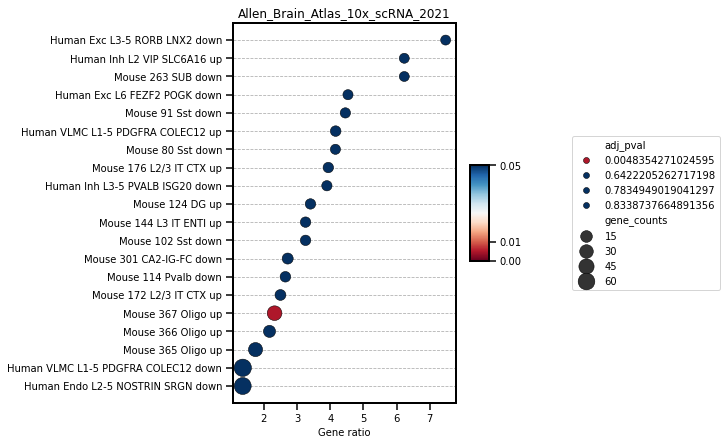

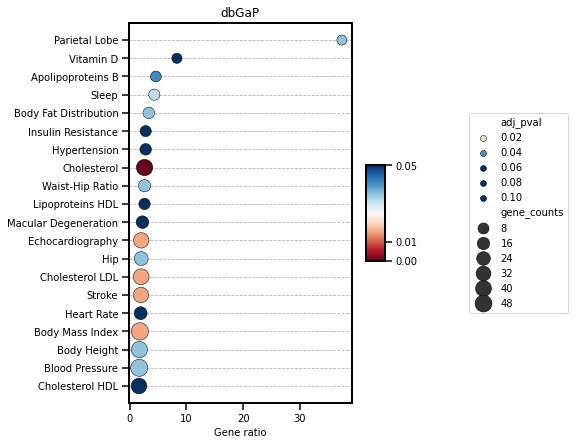

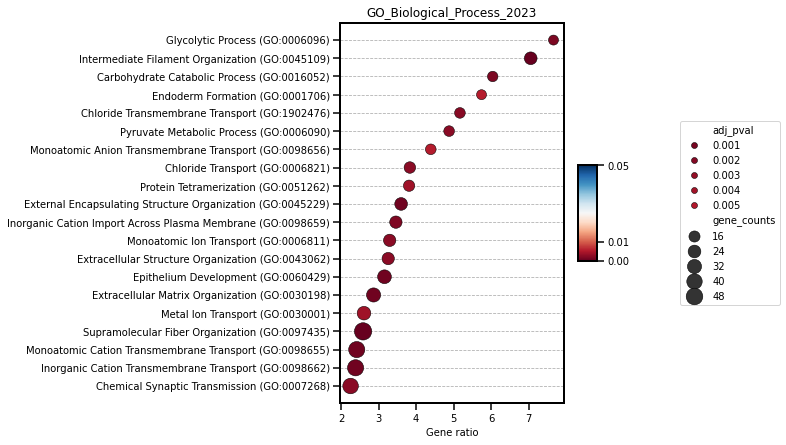

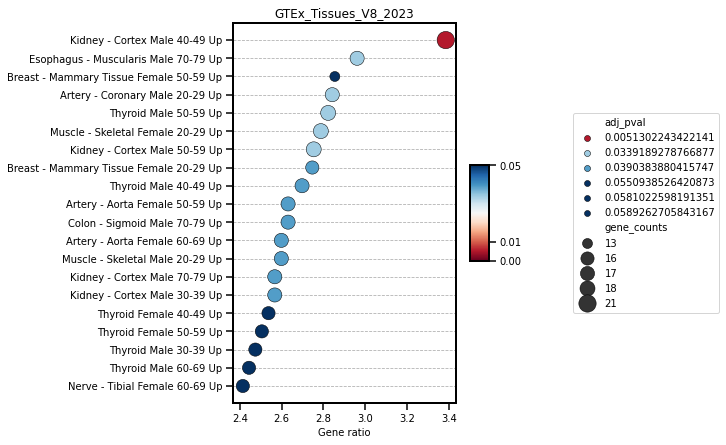

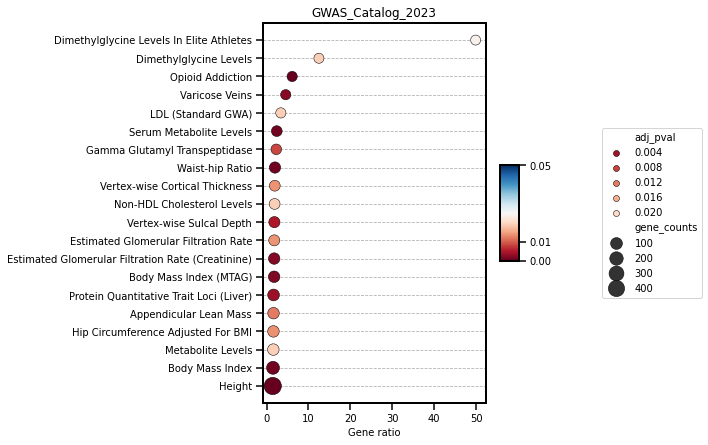

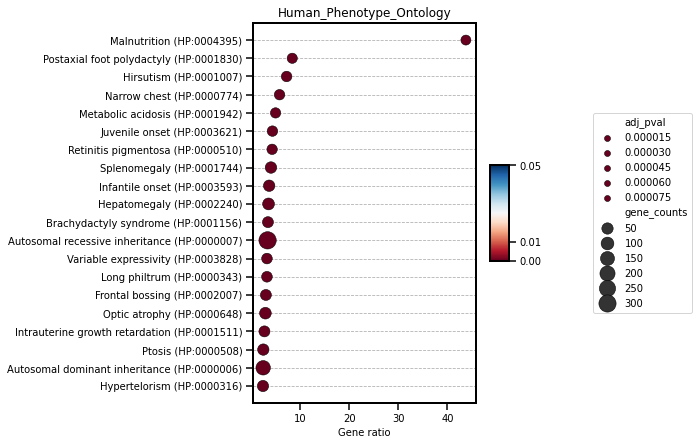

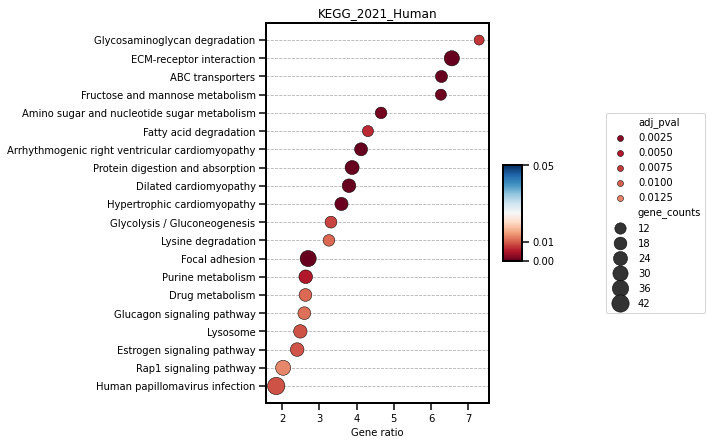

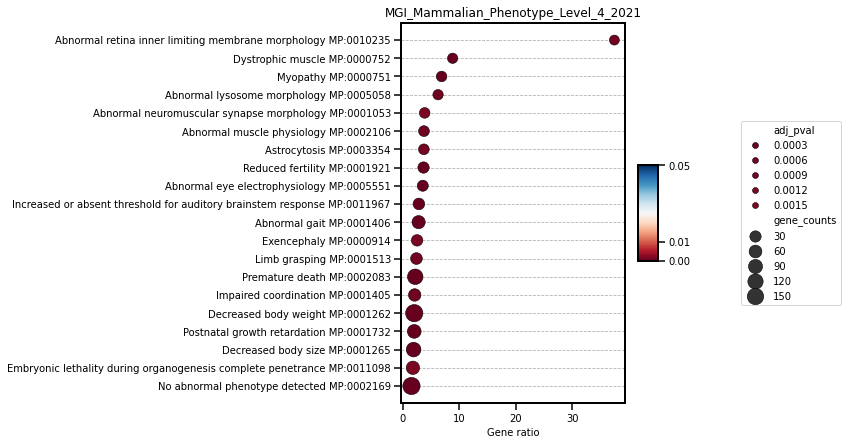

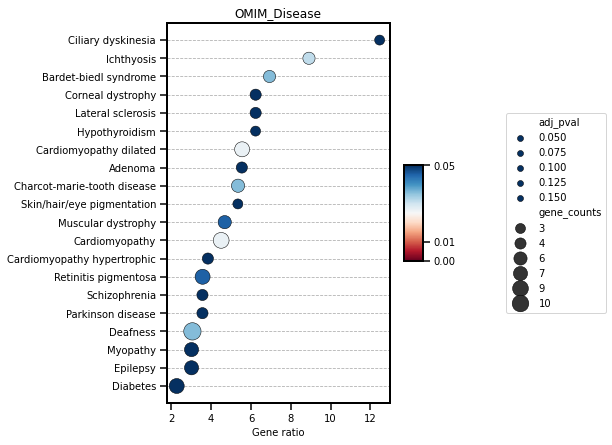

In [14]:

run_enrichment(lifestyle_only_genes, pop_genes, "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/lifestyle_only/")